In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# load custom modules required for jetCLR training
from modules.jet_augs import apply_single_jet_augs, translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets
from modules.jet_augs import shift_eta, shift_phi
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.jet_visualizers import plot_jets_phase_plane, plot_nsubs, plot_mj, plot_mjj


# Load in the processed data

In [2]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"


save_id_dir = "n_sig_4030_n_bkg_8000_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50

path_to_data = path_to_save_dir+save_id_dir
print(path_to_data)


clr_train = np.load(path_to_data+"clr_train.npy")
clr_val = np.load(path_to_data+"clr_val.npy")
data_train = np.load(path_to_data+"data_train.npy")
labels_train = np.load(path_to_data+"labels_train.npy")
data_val = np.load(path_to_data+"data_val.npy")
labels_val = np.load(path_to_data+"labels_val.npy")
data_test_f = np.load(path_to_data+"data_test_f.npy")
labels_test_f = np.load(path_to_data+"labels_test_f.npy")

# print data dimensions
print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
print( "CLR val data shape: " + str( clr_val.shape ), flush=True)
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data/n_sig_4030_n_bkg_8000_n_nonzero_50_n_pad_0_n_jet_2/
CLR training data shape: (9624, 3, 102)
CLR val data shape: (2406, 3, 102)
BC training data shape: (8421, 3, 102)
BC training labels shape: (8421,)
BC val data shape: (1804, 3, 102)
BC val labels shape: (1804,)
BC test data shape: (1804, 3, 102)
BC test labels shape: (1804,)


# Plot the jet constituents next to the augmented versions

In [3]:
#path_to_data_storage = "/clusterfs/ml4hep/rrmastandrea/processed_data/"+"dijet"+"/"

#high_mass_consits_wjet_deltaJ1 = np.load(path_to_data_storage+"50_jets_J1_pi_2.npy")

max_pt = np.max(clr_train[0][0])
ptcm = 5*max_pt

rot = False
trs = False
trsw = .5
dis = False
ptst = .1
col = True
ptcm = 1

np.random.seed(0)



orig_events, mod_events = apply_single_jet_augs(clr_train, 2, "J1_phi_only_pi_2", rot, trs, dis, col)

print(orig_events[1][0][:])
print(mod_events[1][0][:])

print(sum(orig_events[1][0][:]))
print(sum(mod_events[1][0][:]))
#mod_events = shift_phi(mod_events)



#mod_events = shift_eta(mod_events)




#for index_to_plot in range(3):

  
#    plot_jets_phase_plane(orig_events[index_to_plot], mod_events[index_to_plot], .5, xlims=(-3,3), ylims=(-3,3))

    


[285.97747803 262.48712158 214.92817688 129.6416626  117.68864441
 111.28666687  66.7428894   55.50513077  45.47164917  42.15271759
  26.81960297  26.20140266  17.20608711  16.85195541  16.50372505
  15.07640839  14.06130028  12.68602657  12.32116699  12.25113201
  12.2295866   11.3848238   11.08015537  10.68054962  10.36848736
  10.24290562   9.67082787   9.37338924   9.36174488   8.20859051
   7.3012042    6.27259302   6.1786623    6.0911727    5.85399866
   5.78002882   5.75421476   5.1620636    4.97154284   4.8177309
   4.39212513   4.13790131   4.07342243   3.97718573   3.4687295
   2.93692565   2.92610669   2.90579557   2.7165494    2.70009494
 356.01177979 235.36668396  84.89144897  79.88288879  67.9963913
  66.63404846  65.80249786  61.14349747  51.9460144   46.88373184
  46.8289299   43.1870575   40.78447342  37.78722     35.19151688
  31.52543831  31.22504997  29.39108086  26.86074829  21.81142616
  20.84430885  17.25367165  17.0721035   15.57012177  13.78256893
  13.5600605 

# Plot nsubjettiness

In [4]:
# calculate n sub jettiness

# split the list of events into a larger list of jets

#orig_events_long = np.concatenate(np.split(orig_events, 2, axis = 2), axis = 0)
#mod_events_long = np.concatenate(np.split(mod_events, 2, axis = 2), axis = 0)

orig_events_hardest = np.split(orig_events, 2, axis = 2)[0]
orig_events_second = np.split(orig_events, 2, axis = 2)[1]
mod_events_hardest = np.split(mod_events, 2, axis = 2)[0]
mod_events_second = np.split(mod_events, 2, axis = 2)[1]

In [5]:
#plot_nsubs(orig_events_hardest,mod_events_hardest,title=" hardest mass")
#plot_nsubs(orig_events_second,mod_events_second,title=" second mass")

In [6]:
#plot_mj(orig_events_hardest,mod_events_hardest, title=" hardest mass")
#plot_mj(orig_events_second,mod_events_second, title=" second mass")

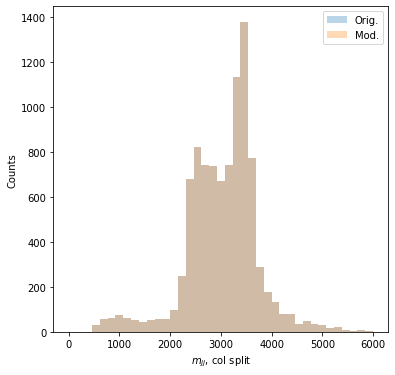

In [9]:
plot_mjj(orig_events_hardest, orig_events_second, mod_events_hardest, mod_events_second, bins = np.linspace(0,6000,40), title = ", col split")




In [8]:
def mjj_test(hard_orig, hard_mod, second_orig, second_mod):
    
    """
    INPUT: np.arrays (# jets, 3, # constituents) where the 1-index goes through (pT, eta, phi)
    
    OUTPUT: np.array containing mjj
    """
    mjjs = []
    
    #for event_id in range(hard_orig.shape[0]):
    for event_id in range(100):
        
        # cluster hardest orig
        collision_HO =  np.array([(hard_orig[event_id][0,i],hard_orig[event_id][1,i],hard_orig[event_id][2,i],0) 
                                 for i in range(hard_orig[event_id].shape[1])],
                     np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))  
        sequence_HO = cluster(collision_HO, R=100, p=-1) # ridiculously large R as we want to include everything
        jet_HO = sequence_HO.inclusive_jets()[0]
        
        # cluster second orig
        collision_SO =  np.array([(second_orig[event_id][0,i],second_orig[event_id][1,i],second_orig[event_id][2,i],0) 
                                 for i in range(second_orig[event_id].shape[1])],
                     np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))  
        sequence_SO = cluster(collision_SO, R=100, p=-1) # ridiculously large R as we want to include everything
        jet_SO = sequence_SO.inclusive_jets()[0]
        
        # cluster hardest mod
        collision_HM =  np.array([(hard_mod[event_id][0,i],hard_mod[event_id][1,i],hard_mod[event_id][2,i],0) 
                                 for i in range(hard_mod[event_id].shape[1])],
                     np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))  
        sequence_HM = cluster(collision_HM, R=100, p=-1) # ridiculously large R as we want to include everything
        jet_HM = sequence_HM.inclusive_jets()[0]
        
        # cluster second md
        collision_SM =  np.array([(second_mod[event_id][0,i],second_mod[event_id][1,i],second_mod[event_id][2,i],0) 
                                 for i in range(second_mod[event_id].shape[1])],
                     np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))  
        sequence_SM = cluster(collision_SM, R=100, p=-1) # ridiculously large R as we want to include everything
        jet_SM = sequence_SM.inclusive_jets()[0]
        

        
        if jet_HO.pt != jet_HM.pt:
            print("Hardest jet doesn't match", event_id)
            
            print(jet_HO)
            print("Pt sum:",sum(hard_orig[event_id][0]))
            print(jet_HM)
            print("Pt sum:",sum(hard_mod[event_id][0]))
            print()
            
        #if jet_SO.pt != jet_SM.pt:
            #print("Second jet doesn't match", event_id)
        
     
        
    
        
    
    
        # calculate mjj   
        # mjj = sqrt((E1 + E2)^2 - (px1 + px2)^2 - (py1 + py2)^2 - (pz1 + pz2)^2)
        #loc_mjj = np.sqrt((jet_1.e + jet_2.e)**2 - (jet_1.px+jet_2.px)**2 - (jet_1.py+jet_2.py)**2 - (jet_1.pz+jet_2.pz)**2)

        #mjjs.append(loc_mjj)
        
        # cluster jet 2

    #return np.array(mjjs)


mjj_test(orig_events_hardest, mod_events_hardest, orig_events_second, mod_events_second)




NameError: name 'cluster' is not defined